# TensorRT quantization

In [1]:
from io import BytesIO
import onnx
import torch
from ultralytics import YOLO
from TensorRT.models.common import PostDetect, optim
from TensorRT.models import EngineBuilder
import onnxsim

### Pytorch to ONNX model

In [2]:
pt_model = 'models/Pytorch/fp32.pt'

PostDetect.conf_thres = 0.25
PostDetect.iou_thres = 0.65
PostDetect.topk = 100

b = 1
YOLOv8 = YOLO(pt_model)
model = YOLOv8.model.fuse().eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for m in model.modules():
    optim(m)
    m.to(device)
model.to(device)
fake_input = torch.randn((1,3,640,640)).to(device)
for _ in range(2):
    model(fake_input)
save_path = "models/TensorRT/onnx_model.onnx"
with BytesIO() as f:
    torch.onnx.export(
        model,
        fake_input,
        f,
        opset_version=11,
        input_names=['images'],
        output_names=['num_dets', 'bboxes', 'scores', 'labels'])
    f.seek(0)
    onnx_model = onnx.load(f)
onnx.checker.check_model(onnx_model)
shapes = [b, 1, b, 100, 4, b, 100, b, 100]
for i in onnx_model.graph.output:
    for j in i.type.tensor_type.shape.dim:
        j.dim_param = str(shapes.pop(0))
try:
    onnx_model, check = onnxsim.simplify(onnx_model)
    assert check, 'assert check failed'
except Exception as e:
    print(f'Simplifier failure: {e}')
onnx.save(onnx_model, save_path)
print(f'ONNX export success, saved as {save_path}')

Model summary (fused): 268 layers, 43607379 parameters, 0 gradients


ONNX export success, saved as models/TensorRT/fp32.onnx


### TensorRT float16 model

In [3]:
onnx_model = 'models/TensorRT/onnx_model.onnx'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

builder = EngineBuilder(onnx_model, device)
builder.seg = True
builder.build(precision='fp16',
              save_path='models/TensorRT/fp16.engine',
              input_shape=[1, 3, 640, 640],
              iou_thres=0.65,
              conf_thres=0.25,
              topk=100)

[08/16/2023-09:31:48] [TRT] [W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[08/16/2023-09:31:48] [TRT] [W] onnx2trt_utils.cpp:400: One or more weights outside the range of INT32 was clamped
[08/16/2023-09:31:48] [TRT] [W] builtin_op_importers.cpp:5221: Attribute class_agnostic not found in plugin node! Ensure that the plugin creator has a default value defined or the engine may fail to build.
[08/16/2023-09:31:48] [TRT] [W] input "images" with shape: (1, 3, 640, 640) dtype: DataType.FLOAT
[08/16/2023-09:31:48] [TRT] [W] output "num_dets" with shape: (1, 1) dtype: DataType.INT32
[08/16/2023-09:31:48] [TRT] [W] output "bboxes" with shape: (1, 100, 4) dtype: DataType.FLOAT
[08/16/2023-09:31:48] [TRT] [W] output "scores" with shape: (1, 100) dtype: DataType.FLOAT
[08/16/2023-09:31:48] [TRT] [W] output "labels" with shape: (1, 100) dtype: DataType.INT32
[08/16/2023-09:31:48]

In [125]:
import cv2
import numpy as np
import random
from TensorRT.models.utils import blob, det_postprocess, letterbox
from TensorRT.models.cudart_api import TRTEngine

with open('coco.names') as f:
    classes = f.read().split('\n')

engine_path = 'models/TensorRT/fp16.engine'
Engine = TRTEngine(engine_path)
H, W = Engine.inp_info[0].shape[-2:]

cap = cv2.VideoCapture('video.mp4')

if (cap.isOpened()== False):
    print("Error opening video stream or file")

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        draw = frame.copy()
        bgr, ratio, dwdh = letterbox(frame, (W, H))
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        tensor = blob(rgb, return_seg=False)
        dwdh = np.array(dwdh * 2, dtype=np.float32)
        tensor = np.ascontiguousarray(tensor)
        # inference
        data = Engine(tensor)
        bboxes, scores, labels = det_postprocess(data)
        bboxes -= dwdh
        bboxes /= ratio

        for (bbox, score, label) in zip(bboxes, scores, labels):
            bbox = bbox.round().astype(np.int32).tolist()
            cls_id = int(label)
            cls = classes[cls_id]
            color = (255, 0, 0)
            cv2.rectangle(draw, bbox[:2], bbox[2:], color, 2)
            cv2.putText(draw, f'{cls}:{score:.3f}', (bbox[0], bbox[1] - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [225, 255, 255], thickness=2)

        cv2.imshow('video', draw)
    else:
        break

    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

[08/15/2023-18:06:25] [TRT] [W] TensorRT was linked against cuDNN 8.9.0 but loaded cuDNN 8.3.2
[08/15/2023-18:06:25] [TRT] [W] TensorRT was linked against cuDNN 8.9.0 but loaded cuDNN 8.3.2


### TensorRT float32 model

In [4]:
onnx_model = 'models/TensorRT/onnx_model.onnx'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

builder = EngineBuilder(onnx_model, device)
builder.seg = True
builder.build(precision='fp32',
              save_path='models/TensorRT/fp32.engine',
              input_shape=[1, 3, 640, 640],
              iou_thres=0.65,
              conf_thres=0.25,
              topk=100)

[08/16/2023-09:43:32] [TRT] [W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[08/16/2023-09:43:32] [TRT] [W] onnx2trt_utils.cpp:400: One or more weights outside the range of INT32 was clamped
[08/16/2023-09:43:32] [TRT] [W] builtin_op_importers.cpp:5221: Attribute class_agnostic not found in plugin node! Ensure that the plugin creator has a default value defined or the engine may fail to build.
[08/16/2023-09:43:32] [TRT] [W] input "images" with shape: (1, 3, 640, 640) dtype: DataType.FLOAT
[08/16/2023-09:43:32] [TRT] [W] output "num_dets" with shape: (1, 1) dtype: DataType.INT32
[08/16/2023-09:43:32] [TRT] [W] output "bboxes" with shape: (1, 100, 4) dtype: DataType.FLOAT
[08/16/2023-09:43:32] [TRT] [W] output "scores" with shape: (1, 100) dtype: DataType.FLOAT
[08/16/2023-09:43:32] [TRT] [W] output "labels" with shape: (1, 100) dtype: DataType.INT32
[08/16/2023-09:43:33]

### TensorRT int8 model

In [5]:
onnx_model = 'models/TensorRT/onnx_model.onnx'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

builder = EngineBuilder(onnx_model, device)
builder.seg = True
builder.build(precision='int8',
              save_path='models/TensorRT/int8.engine',
              input_shape=[1, 3, 640, 640],
              iou_thres=0.65,
              conf_thres=0.25,
              topk=100)

[08/16/2023-09:46:57] [TRT] [W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[08/16/2023-09:46:57] [TRT] [W] onnx2trt_utils.cpp:400: One or more weights outside the range of INT32 was clamped
[08/16/2023-09:46:57] [TRT] [W] builtin_op_importers.cpp:5221: Attribute class_agnostic not found in plugin node! Ensure that the plugin creator has a default value defined or the engine may fail to build.
[08/16/2023-09:46:57] [TRT] [W] input "images" with shape: (1, 3, 640, 640) dtype: DataType.FLOAT
[08/16/2023-09:46:57] [TRT] [W] output "num_dets" with shape: (1, 1) dtype: DataType.INT32
[08/16/2023-09:46:57] [TRT] [W] output "bboxes" with shape: (1, 100, 4) dtype: DataType.FLOAT
[08/16/2023-09:46:57] [TRT] [W] output "scores" with shape: (1, 100) dtype: DataType.FLOAT
[08/16/2023-09:46:57] [TRT] [W] output "labels" with shape: (1, 100) dtype: DataType.INT32
[08/16/2023-09:46:57]

# Pytorch quantization

### Pytorch float32 model

In [427]:
from ultralytics import YOLO
import torch

In [428]:
model = YOLO('models/Pytorch/fp32.pt')

Weights = []
for i in model.model.fuse().parameters():
    Weights.append(i.data)
print(f"Model have {len(Weights)} layers with trainable parameters.\nExample first layer parameters:")
print(Weights[0][0][0])
print("Type:", Weights[0][0][0].dtype)

Model summary (fused): 268 layers, 43607379 parameters, 0 gradients


Model have 207 layers with trainable parameters.
Example first layer parameters:
tensor([[  2.2518,   6.2326,  -8.2276],
        [  4.5724,   0.4449,  -6.3151],
        [ -4.7604, -11.2453,  15.4829]])
Type: torch.float32


### Pytorch int8 model

In [429]:
import pickle
from torch.ao.quantization import quantize_dynamic

model_to_quant = torch.load("models/Pytorch/fp32.pt")
model_to_quant['model'] = quantize_dynamic(model_to_quant['model'].eval(), qconfig_spec=None, dtype=torch.quint8, mapping=None, inplace=False)

torch.save(model_to_quant, 'models/Pytorch/int8.pt', pickle_module=pickle)

In [430]:
int8 = YOLO('models/Pytorch/int8.pt')

Weights = []
for i in int8.model.fuse().parameters():
    Weights.append(i.data)
print(f"Model have {len(Weights)} layers with trainable parameters.\nExample first layer parameters:")
print(Weights[0][0][0])
print("Type:", Weights[0][0][0].dtype)

res = int8.predict('rasm.jpg', save=True)

Model summary (fused): 268 layers, 43607379 parameters, 0 gradients



Model have 207 layers with trainable parameters.
Example first layer parameters:
tensor([[  2.2518,   6.2326,  -8.2276],
        [  4.5724,   0.4449,  -6.3151],
        [ -4.7604, -11.2453,  15.4829]])
Type: torch.float32


image 1/1 /home/airi/Desktop/Shaxboz/Quantization/rasm.jpg: 480x640 25 Faces, 20.6ms
Speed: 1.0ms preprocess, 20.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict8


In [432]:
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

# compare the sizes
f=print_size_of_model(model.model, "fp32")
q=print_size_of_model(int8.model, "int8")
print("{0:.2f} times smaller".format(f/q))

model:  fp32  	 Size (KB): 174493.488
model:  int8  	 Size (KB): 174496.368
1.00 times smaller


# ONNX quantization

### ONNX float32 model

In [27]:
from ultralytics import YOLO

YOLOv8 = YOLO('models/Pytorch/fp32.pt')
model = YOLOv8.model.fuse().eval()

# Input to the model
x = torch.randn(1, 3, 640, 640, requires_grad=True)
torch_out = model(x)

save_path = "models/ONNX/fp32.onnx"
# Export the model
torch.onnx.export(model,                      # model being run
                  x,                          # model input (or a tuple for multiple inputs)
                  save_path,                  # where to save the model (can be a file or file-like object)
                  export_params=True,         # store the trained parameter weights inside the model file
                  opset_version=11,           # the ONNX version to export the model to
                  do_constant_folding=True,   # whether to execute constant folding for optimization
                  input_names = ['images'],   # the model's input names
                  output_names = ['output0'], # the model's output names
                 )
print(f'ONNX export success, saved as {save_path}')

Model summary (fused): 268 layers, 43607379 parameters, 0 gradients


ONNX export success, saved as models/ONNX/fp32.onnx


Info:
Model: Onnx float32 model
FPS: 3.3728308174300152


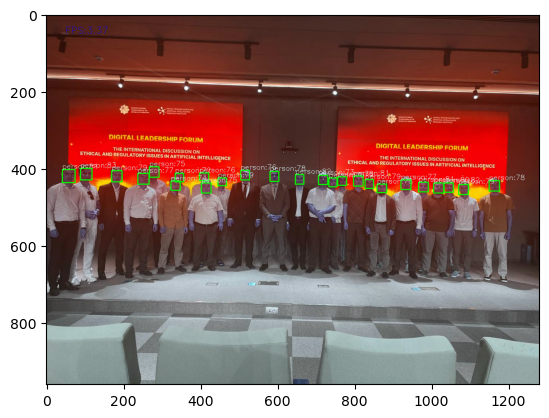

In [477]:
import onnxruntime
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

# auxiliary functions
def box_iou_batch(
	boxes_a: np.ndarray, boxes_b: np.ndarray
) -> np.ndarray:

    def box_area(box):
        return (box[2] - box[0]) * (box[3] - box[1])

    area_a = box_area(boxes_a.T)
    area_b = box_area(boxes_b.T)

    top_left = np.maximum(boxes_a[:, None, :2], boxes_b[:, :2])
    bottom_right = np.minimum(boxes_a[:, None, 2:], boxes_b[:, 2:])

    area_inter = np.prod(
    	np.clip(bottom_right - top_left, a_min=0, a_max=None), 2)
        
    return area_inter / (area_a[:, None] + area_b - area_inter)

def non_max_suppression(
   predictions: np.ndarray, iou_threshold: float = 0.5
) -> np.ndarray:
    rows, columns = predictions.shape

    sort_index = np.flip(predictions[:, 4].argsort())
    predictions = predictions[sort_index]

    boxes = predictions[:, :4]
    categories = predictions[:, 5]
    ious = box_iou_batch(boxes, boxes)
    ious = ious - np.eye(rows)
    # print(ious)

    keep = np.ones(rows, dtype=bool)

    for index, (iou, category) in enumerate(zip(ious, categories)):
        if not keep[index]:
            continue

        condition = (iou > iou_threshold) & (categories == category)
        keep = keep & ~condition

    return keep[sort_index.argsort()]

def xywh2xyxy(x):
    # Convert bounding box (x, y, w, h) to bounding box (x1, y1, x2, y2)
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y

# onnx load
opt_session = onnxruntime.SessionOptions()
opt_session.enable_mem_pattern = False
opt_session.enable_cpu_mem_arena = False
opt_session.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_DISABLE_ALL

model_path = 'models/ONNX/fp32.onnx'
EP_list = ['CPUExecutionProvider']

ort_session = onnxruntime.InferenceSession(model_path, providers=EP_list)

model_inputs = ort_session.get_inputs()
input_names = [model_inputs[i].name for i in range(len(model_inputs))]
input_shape = model_inputs[0].shape

model_output = ort_session.get_outputs()
output_names = [model_output[i].name for i in range(len(model_output))]

with open('coco.names') as f:
    classes = f.read().split('\n')

frame = cv2.imread('rasm.jpg')
now = time.time()
image_height, image_width = frame.shape[:2]
#         Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

input_height, input_width = input_shape[2:]
image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
resized = cv2.resize(image_rgb, (input_width, input_height))

# Scale input pixel value to 0 to 1
input_image = resized / 255.0
input_image = input_image.transpose(2,0,1)
input_tensor = input_image[np.newaxis, :, :, :].astype(np.float32)

outputs = ort_session.run(output_names, {input_names[0]: input_tensor})[0]
predictions = np.squeeze(outputs).T
conf_thresold = 0.6
# Filter out object confidence scores below threshold
scores = np.max(predictions[:, 4:], axis=1)
predictions = predictions[scores > conf_thresold, :]
scores = scores[scores > conf_thresold]
class_ids = np.argmax(predictions[:, 4:], axis=1)

# Get bounding boxes for each object
boxes = predictions[:, :4]

#rescale box
input_shape = np.array([input_width, input_height, input_width, input_height])
boxes = np.divide(boxes, input_shape, dtype=np.float32)
boxes *= np.array([image_width, image_height, image_width, image_height])
boxes = boxes.astype(np.int32)
boxes = xywh2xyxy(boxes)
# print(boxes)

indices = non_max_suppression(np.concatenate((boxes, np.expand_dims(scores, axis=1), np.expand_dims(class_ids, axis=1)), axis=1), 0.3)
for (bbox, score, label) in zip(boxes[indices], scores[indices], class_ids[indices]):
    bbox = bbox.round().astype(np.int32).tolist()
    cls = classes[int(label)]
    color = (0,255,0)
    cv2.rectangle(frame, tuple(bbox[:2]), tuple(bbox[2:]), color, 2)
    cv2.putText(frame,
                f'{cls}:{int(score*100)}', (bbox[0], bbox[1] - 2),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.60, [225, 255, 255],
                thickness=1)
fps = 1 / (time.time() - now)
cv2.putText(frame,
            f'FPS:{round(fps, 2)}', (50, 50),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8, [0,0,255],
            thickness=1)
print("Info:\nModel: Onnx float32 model")
print('FPS:', fps)
plt.imshow(frame)

In [439]:
from onnx import numpy_helper
_model = onnx.load( "models/ONNX/fp32.onnx")
INTIALIZERS=_model.graph.initializer
Weight=[]
for initializer in INTIALIZERS:
    W = numpy_helper.to_array(initializer)
    Weight.append(W)
print(f"Model have {len(Weights)} layers with trainable parameters.\nExample first layer parameters:")
print(Weights[0][0][0])
print("Type:", Weights[0][0][0].dtype)

Model have 207 layers with trainable parameters.
Example first layer parameters:
tensor([[  2.2518,   6.2326,  -8.2276],
        [  4.5724,   0.4449,  -6.3151],
        [ -4.7604, -11.2453,  15.4829]])
Type: torch.float32


In [440]:
# Quantize function

import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
from onnxconverter_common import float16

def quantize_onnx_model(
        onnx_model_path,
        quantized_model_path,
        qtype = "qint8",
        verbose = False,
    ):
    """Takes model converted to onnx runtime and applies pruning.

    Args:
        onnx_model_path: path to onnx model.
        quantized_model_path: path to quantized model.
        qtype: Type of weights in quantized model.
            Can be `quint8` or `qint8`. Defaults to "qint8".
        verbose: If set to True prints model size before
            and after quantization. Defaults to False.

    Raises:
        ValueError: If qtype is not understood.
    """
    type_mapping = {
        "qint8": QuantType.QInt8,
        "quint8": QuantType.QUInt8,
        "fp16" : float16
    }
    if qtype not in type_mapping.keys():
        raise ValueError(
            "type should be string one of 'quint8', 'qint8' or 'fp16'. Got {}".format(qtype)
        )
    if qtype != "fp16":
        quantize_dynamic(
            onnx_model_path, quantized_model_path, weight_type=type_mapping[qtype]
        )
    else:
        model = onnx.load(onnx_model_path)
        model_fp16 = float16.convert_float_to_float16(model)
        onnx.save(model_fp16, quantized_model_path)
    if verbose:
        v_str = (
            "Model size before quantization (MB):"
            f"{os.path.getsize(onnx_model_path) / 2**20:.2f}\n"
            "Model size after quantization (MB):"
            f"{os.path.getsize(quantized_model_path) / 2**20:.2f}"
        )
        print("Done.")
        print(v_str)
        print(f"Quantized model saved to {quantized_model_path}.")

### ONNX float16 model

In [441]:
quantize_onnx_model('models/ONNX/fp32.onnx', 'models/ONNX/fp16.onnx', qtype = "fp16", verbose=True)

Done.
Model size before quantization (MB):166.59
Model size after quantization (MB):83.36
Quantized model saved to models/ONNX/fp16.onnx.


Info:
Model: Onnx float16 model
FPS: 2.0075000586316007


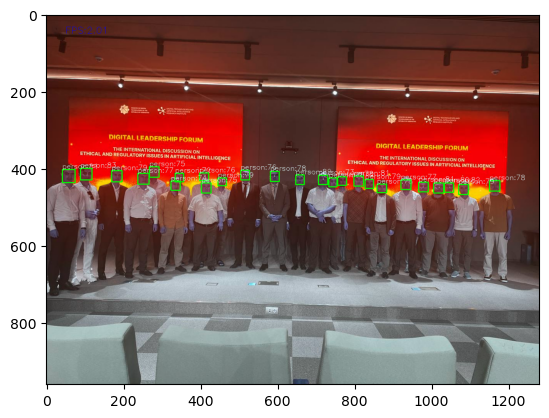

In [478]:
import onnxruntime
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

# auxiliary functions
def box_iou_batch(
	boxes_a: np.ndarray, boxes_b: np.ndarray
) -> np.ndarray:

    def box_area(box):
        return (box[2] - box[0]) * (box[3] - box[1])

    area_a = box_area(boxes_a.T)
    area_b = box_area(boxes_b.T)

    top_left = np.maximum(boxes_a[:, None, :2], boxes_b[:, :2])
    bottom_right = np.minimum(boxes_a[:, None, 2:], boxes_b[:, 2:])

    area_inter = np.prod(
    	np.clip(bottom_right - top_left, a_min=0, a_max=None), 2)
        
    return area_inter / (area_a[:, None] + area_b - area_inter)

def non_max_suppression(
   predictions: np.ndarray, iou_threshold: float = 0.5
) -> np.ndarray:
    rows, columns = predictions.shape

    sort_index = np.flip(predictions[:, 4].argsort())
    predictions = predictions[sort_index]

    boxes = predictions[:, :4]
    categories = predictions[:, 5]
    ious = box_iou_batch(boxes, boxes)
    ious = ious - np.eye(rows)
    # print(ious)

    keep = np.ones(rows, dtype=bool)

    for index, (iou, category) in enumerate(zip(ious, categories)):
        if not keep[index]:
            continue

        condition = (iou > iou_threshold) & (categories == category)
        keep = keep & ~condition

    return keep[sort_index.argsort()]

def xywh2xyxy(x):
    # Convert bounding box (x, y, w, h) to bounding box (x1, y1, x2, y2)
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y

# onnx load
opt_session = onnxruntime.SessionOptions()
opt_session.enable_mem_pattern = False
opt_session.enable_cpu_mem_arena = False
opt_session.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_DISABLE_ALL

model_path = 'models/ONNX/fp16.onnx'
EP_list = ['CPUExecutionProvider']

ort_session = onnxruntime.InferenceSession(model_path, providers=EP_list)

model_inputs = ort_session.get_inputs()
input_names = [model_inputs[i].name for i in range(len(model_inputs))]
input_shape = model_inputs[0].shape

model_output = ort_session.get_outputs()
output_names = [model_output[i].name for i in range(len(model_output))]

with open('coco.names') as f:
    classes = f.read().split('\n')

frame = cv2.imread('rasm.jpg')
now = time.time()
image_height, image_width = frame.shape[:2]
#         Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

input_height, input_width = input_shape[2:]
image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
resized = cv2.resize(image_rgb, (input_width, input_height))

# Scale input pixel value to 0 to 1
input_image = resized / 255.0
input_image = input_image.transpose(2,0,1)
input_tensor = input_image[np.newaxis, :, :, :].astype(np.float16)

outputs = ort_session.run(output_names, {input_names[0]: input_tensor})[0]
predictions = np.squeeze(outputs).T
conf_thresold = 0.6
# Filter out object confidence scores below threshold
scores = np.max(predictions[:, 4:], axis=1)
predictions = predictions[scores > conf_thresold, :]
scores = scores[scores > conf_thresold]
class_ids = np.argmax(predictions[:, 4:], axis=1)

# Get bounding boxes for each object
boxes = predictions[:, :4]

#rescale box
input_shape = np.array([input_width, input_height, input_width, input_height])
boxes = np.divide(boxes, input_shape, dtype=np.float32)
boxes *= np.array([image_width, image_height, image_width, image_height])
boxes = boxes.astype(np.int32)
boxes = xywh2xyxy(boxes)
# print(boxes)

indices = non_max_suppression(np.concatenate((boxes, np.expand_dims(scores, axis=1), np.expand_dims(class_ids, axis=1)), axis=1), 0.3)
for (bbox, score, label) in zip(boxes[indices], scores[indices], class_ids[indices]):
    bbox = bbox.round().astype(np.int32).tolist()
    cls = classes[int(label)]
    color = (0,255,0)
    cv2.rectangle(frame, tuple(bbox[:2]), tuple(bbox[2:]), color, 2)
    cv2.putText(frame,
                f'{cls}:{int(score*100)}', (bbox[0], bbox[1] - 2),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.60, [225, 255, 255],
                thickness=1)
fps = 1 / (time.time() - now)
cv2.putText(frame,
            f'FPS:{round(fps, 2)}', (50, 50),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8, [0,0,255],
            thickness=1)
print("Info:\nModel: Onnx float16 model")
print('FPS:', fps)
plt.imshow(frame)

In [444]:
from onnx import numpy_helper
_model = onnx.load( "models/ONNX/fp16.onnx")
INTIALIZERS=_model.graph.initializer
Weights=[]
for initializer in INTIALIZERS:
    W = numpy_helper.to_array(initializer)
    Weights.append(W)
print(f"Model have {len(Weights)} layers with trainable parameters.\nExample first layer parameters:")
print(Weights[0][0][0])
print("Type:", Weights[0][0][0].dtype)

Model have 207 layers with trainable parameters.
Example first layer parameters:
[[      2.252      6.2344     -8.2266]
 [     4.5742     0.44482     -6.3164]
 [    -4.7617     -11.242      15.484]]
Type: float16


### ONNX int8 model

In [455]:
quantize_onnx_model('models/ONNX/fp32.onnx', 'models/ONNX/int8.onnx', qtype = "quint8", verbose=True)

Done.
Model size before quantization (MB):166.59
Model size after quantization (MB):42.05
Quantized model saved to models/ONNX/int8.onnx.


When we quantize model to int8, all weights are not quantized. 
Some layers remain in their previous state, and some are quantized.

In [456]:
from onnx import numpy_helper
_model = onnx.load( "models/ONNX/int8.onnx")
INTIALIZERS=_model.graph.initializer
Weights=[]
for initializer in INTIALIZERS:
    W = numpy_helper.to_array(initializer)
    Weights.append(W)
print(f"Model have {len(Weights)} layers with trainable parameters.\nExample first layer parameters:")
print(Weights[-1])
print("Type:", Weights[-1].dtype)

Model have 539 layers with trainable parameters.
Example first layer parameters:
[[[[  0]]

  [[ 17]]

  [[ 34]]

  [[ 51]]

  [[ 68]]

  [[ 85]]

  [[102]]

  [[119]]

  [[136]]

  [[153]]

  [[170]]

  [[187]]

  [[204]]

  [[221]]

  [[238]]

  [[255]]]]
Type: uint8


Info:
Model: Onnx int8 model
FPS: 1.4385391483052432


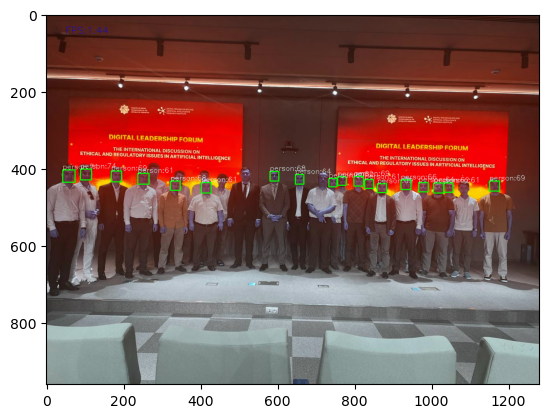

In [470]:
import onnxruntime
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

# auxiliary functions
def box_iou_batch(
	boxes_a: np.ndarray, boxes_b: np.ndarray
) -> np.ndarray:

    def box_area(box):
        return (box[2] - box[0]) * (box[3] - box[1])

    area_a = box_area(boxes_a.T)
    area_b = box_area(boxes_b.T)

    top_left = np.maximum(boxes_a[:, None, :2], boxes_b[:, :2])
    bottom_right = np.minimum(boxes_a[:, None, 2:], boxes_b[:, 2:])

    area_inter = np.prod(
    	np.clip(bottom_right - top_left, a_min=0, a_max=None), 2)
        
    return area_inter / (area_a[:, None] + area_b - area_inter)

def non_max_suppression(
   predictions: np.ndarray, iou_threshold: float = 0.5
) -> np.ndarray:
    rows, columns = predictions.shape

    sort_index = np.flip(predictions[:, 4].argsort())
    predictions = predictions[sort_index]

    boxes = predictions[:, :4]
    categories = predictions[:, 5]
    ious = box_iou_batch(boxes, boxes)
    ious = ious - np.eye(rows)
    # print(ious)

    keep = np.ones(rows, dtype=bool)

    for index, (iou, category) in enumerate(zip(ious, categories)):
        if not keep[index]:
            continue

        condition = (iou > iou_threshold) & (categories == category)
        keep = keep & ~condition

    return keep[sort_index.argsort()]

def xywh2xyxy(x):
    # Convert bounding box (x, y, w, h) to bounding box (x1, y1, x2, y2)
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y

# onnx load
opt_session = onnxruntime.SessionOptions()
opt_session.enable_mem_pattern = False
opt_session.enable_cpu_mem_arena = False
opt_session.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_DISABLE_ALL

model_path = 'models/ONNX/int8.onnx'
EP_list = ['CPUExecutionProvider']

ort_session = onnxruntime.InferenceSession(model_path, providers=EP_list)

model_inputs = ort_session.get_inputs()
input_names = [model_inputs[i].name for i in range(len(model_inputs))]
input_shape = model_inputs[0].shape

model_output = ort_session.get_outputs()
output_names = [model_output[i].name for i in range(len(model_output))]

with open('coco.names') as f:
    classes = f.read().split('\n')

frame = cv2.imread('rasm.jpg')
now = time.time()
image_height, image_width = frame.shape[:2]
#         Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

input_height, input_width = input_shape[2:]
image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
resized = cv2.resize(image_rgb, (input_width, input_height))

# Scale input pixel value to 0 to 1
input_image = resized / 255.0
input_image = input_image.transpose(2,0,1)
input_tensor = input_image[np.newaxis, :, :, :].astype(np.float32)

outputs = ort_session.run(output_names, {input_names[0]: input_tensor})[0]
predictions = np.squeeze(outputs).T
conf_thresold = 0.6
# Filter out object confidence scores below threshold
scores = np.max(predictions[:, 4:], axis=1)
predictions = predictions[scores > conf_thresold, :]
scores = scores[scores > conf_thresold]
class_ids = np.argmax(predictions[:, 4:], axis=1)

# Get bounding boxes for each object
boxes = predictions[:, :4]

#rescale box
input_shape = np.array([input_width, input_height, input_width, input_height])
boxes = np.divide(boxes, input_shape, dtype=np.float)
boxes *= np.array([image_width, image_height, image_width, image_height])
boxes = boxes.astype(np.int32)
boxes = xywh2xyxy(boxes)
# print(boxes)

indices = non_max_suppression(np.concatenate((boxes, np.expand_dims(scores, axis=1), np.expand_dims(class_ids, axis=1)), axis=1), 0.3)
for (bbox, score, label) in zip(boxes[indices], scores[indices], class_ids[indices]):
    bbox = bbox.round().astype(np.int32).tolist()
    cls = classes[int(label)]
    color = (0,255,0)
    cv2.rectangle(frame, tuple(bbox[:2]), tuple(bbox[2:]), color, 2)
    cv2.putText(frame,
                f'{cls}:{int(score*100)}', (bbox[0], bbox[1] - 2),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.60, [225, 255, 255],
                thickness=1)
fps = 1 / (time.time() - now)
cv2.putText(frame,
            f'FPS:{round(fps, 2)}', (50, 50),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8, [0,0,255],
            thickness=1)
print("Info:\nModel: Onnx int8 model")
print('FPS:', fps)
plt.imshow(frame)

## Tensorflow quantization

In tensorflow we use MNIST classification model

In [481]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
import numpy as np

In [482]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# Define the model architecture
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_data=(test_images, test_labels)
)

11490434/11490434 [==============================] - 10s 1us/step
Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3036 - accuracy: 0.9141 - val_loss: 0.1523 - val_accuracy: 0.9595
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1225 - accuracy: 0.9654 - val_loss: 0.0895 - val_accuracy: 0.9743
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0830 - accuracy: 0.9764 - val_loss: 0.0718 - val_accuracy: 0.9776
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0667 - accuracy: 0.9806 - val_loss: 0.0718 - val_accuracy: 0.9782
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0569 - accuracy: 0.9830 - val_loss: 0.0593 - val_accuracy: 0.9807


In [483]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp1wk0mi2b/assets


In [484]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpx61ys06b/assets


In [485]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
        # Model has only one input so each data point has one element.
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpgq_sw9hp/assets
fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


In [486]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


In [487]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmppetflz0h/assets
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


In [488]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [491]:
import pathlib

tflite_models_dir = pathlib.Path("models/Tensorflow/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"fp32.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"int8.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

24608

In [492]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
    global test_images

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices),), dtype=int)
    for i, test_image_index in enumerate(test_image_indices):
        test_image = test_images[test_image_index]
        test_label = test_labels[test_image_index]

        # Check if the input type is quantized, then rescale input data to uint8
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]

        predictions[i] = output.argmax()

    return predictions

In [493]:
import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
    global test_labels

    predictions = run_tflite_model(tflite_file, [test_image_index])

    plt.imshow(test_images[test_image_index])
    template = model_type + " Model \n True:{true}, Predicted:{predict}"
    _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
    plt.grid(False)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


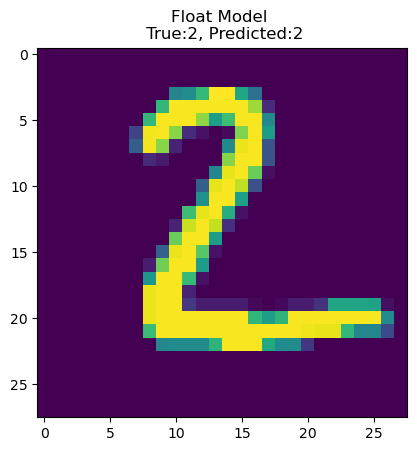

In [494]:
test_model(tflite_model_file, test_image_index, model_type="Float")

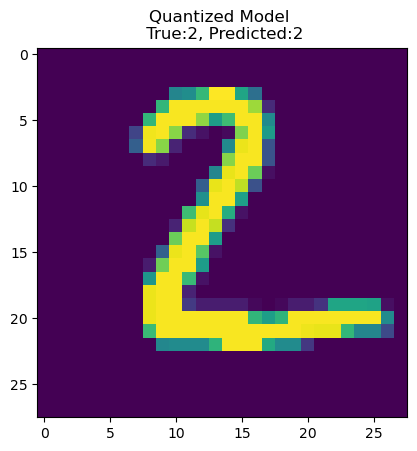

In [495]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

In [496]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
    global test_images
    global test_labels

    test_image_indices = range(test_images.shape[0])
    predictions = run_tflite_model(tflite_file, test_image_indices)

    accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

    print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

In [497]:
evaluate_model(tflite_model_file, model_type="Float")

Float model accuracy is 98.0700% (Number of test samples=10000)


In [498]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 98.0300% (Number of test samples=10000)
